### This notebook is colab specific 

Mount your google drive

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


Now, we use kaggle api to directly load files into colab session instead of manual upload.
This is useful because upload speeds are generally slow.
However, you will need your kaggle api (kaggle.json) with you which can be created in kaggle -> my account

In [2]:
!mkdir .kaggle

In [3]:
!ls -a

.  ..  .config	gdrive	.kaggle  sample_data


now upload kaggle.json to colab, then run the cells below

In [4]:
!mv /content/kaggle.json /content/.kaggle/kaggle.json

In [5]:
!mkdir ~/.kaggle
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json

In [6]:
!chmod 600 /root/.kaggle/kaggle.json

In [7]:
!kaggle datasets download -d jutrera/stanford-car-dataset-by-classes-folder

100% 1.82G/1.83G [00:51<00:00, 41.3MB/s]
100% 1.83G/1.83G [00:51<00:00, 37.8MB/s]


In [8]:
!unzip -q /content/stanford-car-dataset-by-classes-folder.zip

upgrade fastai to fastai 2.0.0

In [9]:
!pip -q install -U fastai pretrainedmodels

     |████████████████████████████████| 358kB 9.6MB/s 
     |████████████████████████████████| 61kB 7.3MB/s 


In [10]:
from fastai.vision.all import *
from pathlib import Path
import pretrainedmodels
import pandas
import os

In [11]:
train_path = '/content/car_data/car_data/train'
test_path = '/content/car_data/car_data/test'

In [12]:
cars = DataBlock(
    blocks = (ImageBlock, CategoryBlock),
    get_items = get_image_files,
    splitter = RandomSplitter(valid_pct = 0.2, seed = 42),
    get_y = parent_label,
    item_tfms = Resize(128)
)
'''
a Fastai API that helps us to create Datasets and Dataloaders for underlying Pytorch
using the splitter parameter, we are splitting the images into 80-20 train-valid split
The items are image files and the labels are folder names
We transform all the images to 128x128
'''

In [13]:
dls = cars.dataloaders(train_path)

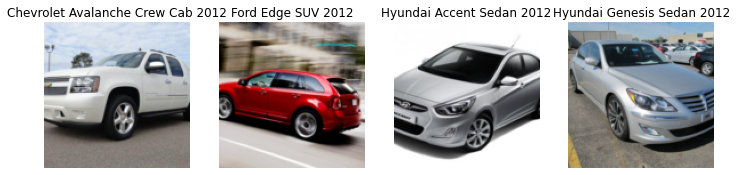

In [14]:
dls.valid.show_batch(max_n = 4, nrows = 1)

In [22]:
#Data augmentation - flip the image, rotation, zoom, etc
cars = cars.new(
    item_tfms = RandomResizedCrop(224, min_scale = 0.5),
    batch_tfms = aug_transforms(do_flip= True, mult=1.0, flip_vert=False, 
                                max_rotate=15.0, min_zoom=1.0, max_zoom=1.1, 
                                max_lighting=0.2, max_warp=0.2, p_affine=0.75, 
                                p_lighting=0.75)
)
dls = cars.dataloaders(train_path)

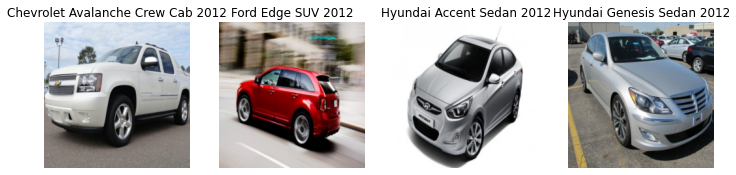

In [23]:
dls.valid.show_batch(max_n = 4, nrows = 1)

In [24]:
# Choosing resnext over resnet as it performed better than resnet on the imagenet dataset
# Downloading the model from pretrainedmodels package available on pypi
def se_resnext50_32x4d(pretrained=False):
    pretrained = 'imagenet' if pretrained else None
    model = pretrainedmodels.se_resnext50_32x4d(pretrained=pretrained) 
    return nn.Sequential(*list(model.children()))

In [25]:
# define a cnn learner, pass a dataloader and the transfer learning model
res_learn = cnn_learner(dls, se_resnext50_32x4d, metrics = accuracy)

# fine_tune helps in freezing the pretrained models weights, then finding the optimum learning rate (lr)
# then unfreezing the weights to train on our datasets. lr can be explicitly given
res_learn.fine_tune(24, lr = 1e-4)

Downloading: "http://data.lip6.fr/cadene/pretrainedmodels/se_resnext50_32x4d-a260b3a4.pth" to /root/.cache/torch/hub/checkpoints/se_resnext50_32x4d-a260b3a4.pth


epoch,train_loss,valid_loss,accuracy,time
0,5.692866,3.958458,0.167076,01:54


epoch,train_loss,valid_loss,accuracy,time
0,3.937200,3.537285,0.225430,02:05
1,3.468402,3.187274,0.289312,02:03
2,2.961323,2.855829,0.344595,02:04
3,2.592365,2.518498,0.393735,02:04
4,2.181790,2.282712,0.439803,02:03
5,1.853321,2.036511,0.485872,02:04
6,1.528146,1.884493,0.515356,02:04
7,1.245406,1.708422,0.552211,02:03
8,1.033570,1.625983,0.568796,02:03
9,0.851705,1.544106,0.578010,02:04


In [26]:
res_learn.save('m1')

Path('models/m1.pth')

In [27]:
res_learn.unfreeze()

SuggestedLRs(lr_min=1.318256749982538e-07, lr_steep=6.30957365501672e-05)

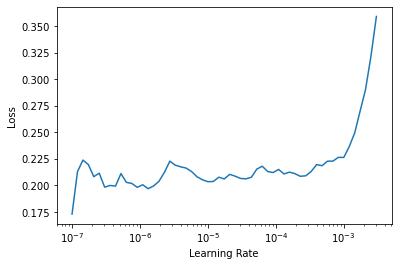

In [28]:
res_learn.lr_find() #find the optimum learning rate

In [29]:
res_learn.load('m1')

In [30]:
res_learn.fit_one_cycle(16, lr_max = 1e-4) #based on lr from previous plot

epoch,train_loss,valid_loss,accuracy,time
0,0.206419,1.160481,0.691032,02:04
1,0.197621,1.132909,0.691032,02:03
2,0.232641,1.186028,0.691646,02:04
3,0.231298,1.138585,0.703931,02:04
4,0.240718,1.072405,0.726044,02:03
5,0.225202,0.981070,0.742015,02:03
6,0.175472,0.964255,0.753071,02:04
7,0.156468,0.962359,0.751229,02:03
8,0.129504,0.908391,0.766585,02:03
9,0.104919,0.917837,0.770270,02:04


In [31]:
res_learn.save('m2')

Path('models/m2.pth')

In [32]:
res_learn.load('m2')

SuggestedLRs(lr_min=4.786300996784121e-05, lr_steep=4.786300905834651e-06)

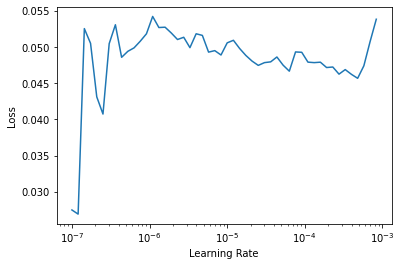

In [33]:
res_learn.unfreeze()
res_learn.lr_find()

In [35]:
# since lr graph shows no signs of reducing loss, do more augmentations
cars = cars.new(
    item_tfms = RandomResizedCrop(299, min_scale = 0.7),
    batch_tfms = aug_transforms(do_flip= True, mult=1.0, flip_vert=False, 
                                max_rotate=10.0, min_zoom=1.0, max_zoom=1.2, 
                                max_lighting=0.2, max_warp=0.2, p_affine=0.75, 
                                p_lighting=0.5)
)
dls = cars.dataloaders(train_path)


In [36]:
res_learn.freeze()

SuggestedLRs(lr_min=1.584893179824576e-05, lr_steep=6.309573450380412e-07)

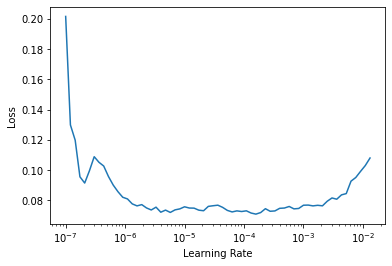

In [37]:
res_learn.lr_find()

In [38]:
res_learn.fit_one_cycle(24, lr_max = slice(1e-5, 1e-3)) #interrupted because accuracy stalled at about 75.6%

Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe


KeyboardInterrupt: ignored

Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe


In [39]:
res_learn.save('m3')
res_learn.load('m3')

In [40]:
res_learn.unfreeze()

SuggestedLRs(lr_min=6.309573450380412e-08, lr_steep=9.120108734350652e-05)

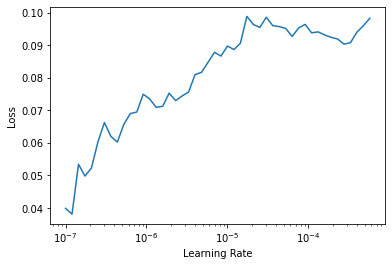

In [42]:
res_learn.lr_find()

In [45]:
res_learn.freeze()

SuggestedLRs(lr_min=2.7542287716642023e-05, lr_steep=9.12010818865383e-07)

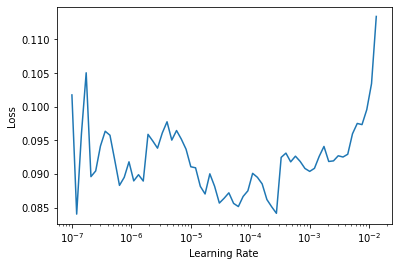

In [46]:
res_learn.lr_find()

SuggestedLRs(lr_min=1.0964781722577755e-07, lr_steep=3.981071586167673e-06)

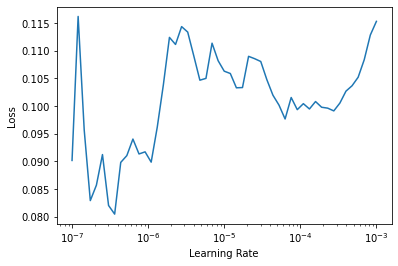

In [55]:
res_learn.unfreeze()
res_learn.lr_find()
# out of ideas at the moment reg what needs to be done. 
# No encouragement from any of the graphs

In [160]:
# TODO: Find a better way to test images in the Test_path (i.e test folder)
# Going through every image in every folder. Hummer folder will have all hummer images
# Open every image, append model's predictions to a preds list
# actual labels are stored in act1

df1 = pd.DataFrame(columns = ['actual', 'predicted'])
act1, preds1 = [],[]

for folder in os.listdir(test_path):
    folder_path = os.path.join(test_path, folder)
    for image in os.listdir(folder_path):
        act1.append(folder)
        im_path = os.path.join(folder_path, image)
        pred, _, _ = res_learn.predict(im_path)
        preds1.append(pred)

df1['actual'] = act1 #actual labels
df1['predicted'] = preds1 #predicted labels

df1['check'] = df1['actual'] == df1['predicted'] #compare actual and predicted
100*(df1['check'].value_counts()/len(df1)) # % True vs % False

True     77.278945
False    22.721055
Name: check, dtype: float64

In [161]:
res_learn.export('mymodel.pkl')

In [70]:
res_learn.export('resm4.pkl')

In [97]:
impath = '/content/gdrive/My Drive/downloaded_images_for_testing/maxresdefault.jpg' #camaro image from google

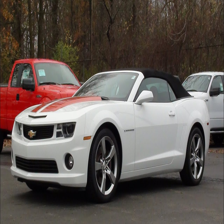

In [98]:
img = Image.open(impath).resize((224, 224)); img

In [166]:
res_learn.predict(impath)[0]

'Chevrolet Camaro Convertible 2012'

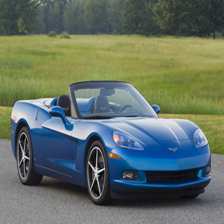

In [110]:
impath2 = '/content/gdrive/My Drive/downloaded_images_for_testing/11-corvette-hero.jpg' #corvette
im2 = Image.open(impath2).resize((224, 224)); im2 

In [167]:
res_learn.predict(impath2)[0]

'Chevrolet Corvette Convertible 2012'